###  Problem definition:
Prediction task to determine whether a person makes over 50k a year.

In [72]:
# Import modules
import pandas as pd
from pandas import set_option
from pandas.plotting import scatter_matrix 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import tree

# Figures inline and set visualization style
%matplotlib inline
sns.set()

### Load dataset

In [73]:
# Import datasets
filename = '../data/adult.data'
names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain','capital-loss', 'hours-per-week', 'native-country','income']
dataset = pd.read_csv(filename, sep=',', names=names)

### Analyze Data

#### Descriptive Statistics

In [74]:
# shape
print(dataset.shape)

(32561, 15)


There are 32,561 instances to work with and the data has 15 attributes.

In [75]:
# data type
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education-num     32561 non-null int64
marital-status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital-gain      32561 non-null int64
capital-loss      32561 non-null int64
hours-per-week    32561 non-null int64
native-country    32561 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


The data types are objects, they need to be converted to corresponding str,int types
and there are no null values

In [76]:
# View the first lines of the dataset
dataset.head(n=4)

age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   

        marital-status          occupation    relationship    race    sex  \
0        Never-married        Adm-clerical   Not-in-family   White   Male   
1   Married-civ-spouse     Exec-managerial         Husband   White   Male   
2             Divorced   Handlers-cleaners   Not-in-family   White   Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black   Male   

   capital-gain  capital-loss  hours-per-week  native-country  income  
0          2174             0              40   United-States   <=50K  
1             0             0              13   United-States   <=50K  
2             0             0              40   United-States   <=50K  
3             0             0              40   United-States   <=50K

In [77]:
# View the last lines of the dataset
dataset.tail(4)

age      workclass  fnlwgt education  education-num  \
32557   40        Private  154374   HS-grad              9   
32558   58        Private  151910   HS-grad              9   
32559   22        Private  201490   HS-grad              9   
32560   52   Self-emp-inc  287927   HS-grad              9   

            marital-status          occupation relationship    race      sex  \
32557   Married-civ-spouse   Machine-op-inspct      Husband   White     Male   
32558              Widowed        Adm-clerical    Unmarried   White   Female   
32559        Never-married        Adm-clerical    Own-child   White     Male   
32560   Married-civ-spouse     Exec-managerial         Wife   White   Female   

       capital-gain  capital-loss  hours-per-week  native-country  income  
32557             0             0              40   United-States    >50K  
32558             0             0              40   United-States   <=50K  
32559             0             0              20   United-States   <=50K  
32560         15024             0              40   United-States    >50K

In [78]:
# class distribution
print(dataset.groupby('income').size())

income
 <=50K    24720
 >50K      7841
dtype: int64


Looking at the breakdown of class values it shows that the classes are not reasonably balanced between '<=50K' and '>50K'

In [79]:
# Summarize the distribution of each attribute.
dataset.describe()

age        fnlwgt  education-num  capital-gain  capital-loss  \
count  32561.000000  3.256100e+04   32561.000000  32561.000000  32561.000000   
mean      38.581647  1.897784e+05      10.080679   1077.648844     87.303830   
std       13.640433  1.055500e+05       2.572720   7385.292085    402.960219   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.178270e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.783560e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.370510e+05      12.000000      0.000000      0.000000   
max       90.000000  1.484705e+06      16.000000  99999.000000   4356.000000   

       hours-per-week  
count    32561.000000  
mean        40.437456  
std         12.347429  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000

From the last analysis data cleaning involved removing ',' character from the attribute values, this is no longer required because the param sep=',' was added to the read_csv was the appropriate delimeter to use for the file.

In [80]:
# Fix headers: Replace "_" with "-" to make usage better
dataset.rename(columns=lambda x: x.replace("-","_"), inplace=True)

### Data Visualizations
Visualizations of individual attributes. It is often useful to look at data
using multiple diferent visualizations in order to spark ideas. 

Below are histograms of each
attribute to get a sense of the data distributions.

#### Univariate plots to better understand each attribute.
Univariate [box and whisker plots]
Given that the input variables are numeric, we can create box and whisker plots of each.
This gives a clearer idea of the distribution of the input attributes

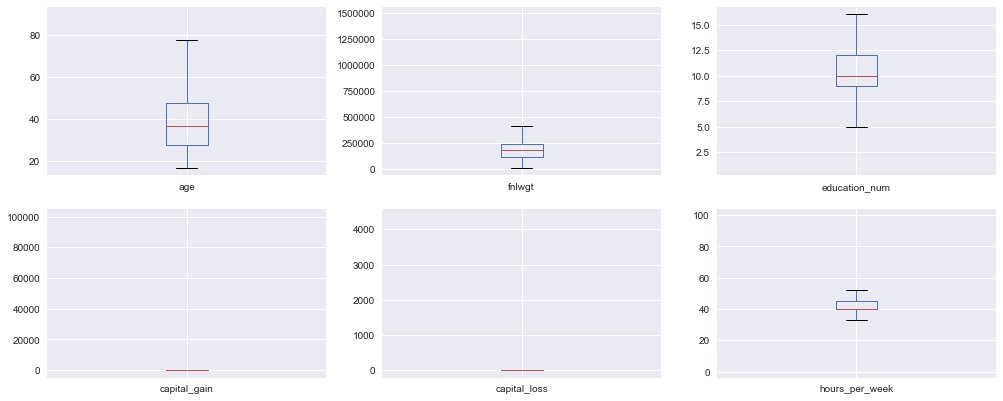

In [81]:
dataset.plot(kind='box', subplots=True, layout=(5,3), sharex=False, sharey=False, figsize=(17,18))
plt.show()

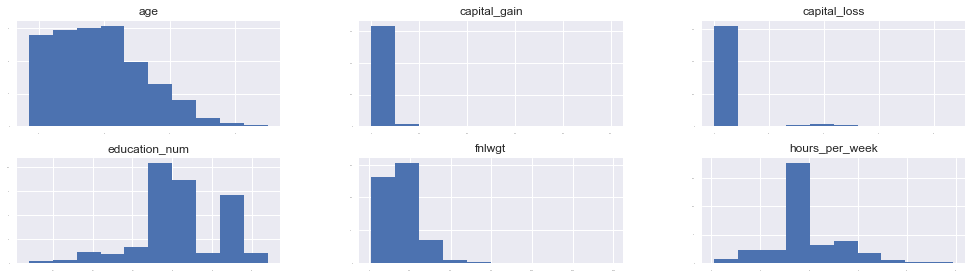

In [82]:
# histograms
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1,figsize=(17,12),layout=(5,3))
plt.show()

capital_gain and capital_loss attributes are not well distributed, this could affect the perfomance of the model, both will be dropped.

In [83]:
dataset = dataset.drop(['capital_gain', 'capital_loss'], axis=1)

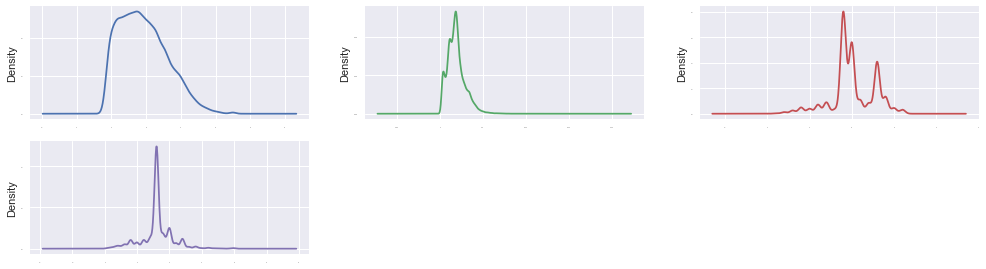

In [84]:
# The same perspective of the data using density plots.
dataset.plot(kind= 'density' , subplots=True, sharex=False, legend=False, fontsize=1,figsize=(17,12),layout=(5,3))
plt.show()

The attributes look like they have a Gaussian distribution. 
This is useful to note as algorithms that can exploit this assumption can be used.

In [85]:
dataset.head()

age          workclass  fnlwgt   education  education_num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital_status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   hours_per_week  native_country  income  
0              40   United-States   <=50K  
1              13   United-States   <=50K  
2              40   United-States   <=50K  
3              40   United-States   <=50K  
4              40            Cuba   <=50K

#### Multivariate plots to better understand the relationships between attributes.
Now we can look at the interactions between the variables.
First, let’s look at scatterplots of all pairs of attributes. 
This can be helpful to spot structured relationships between input variables.

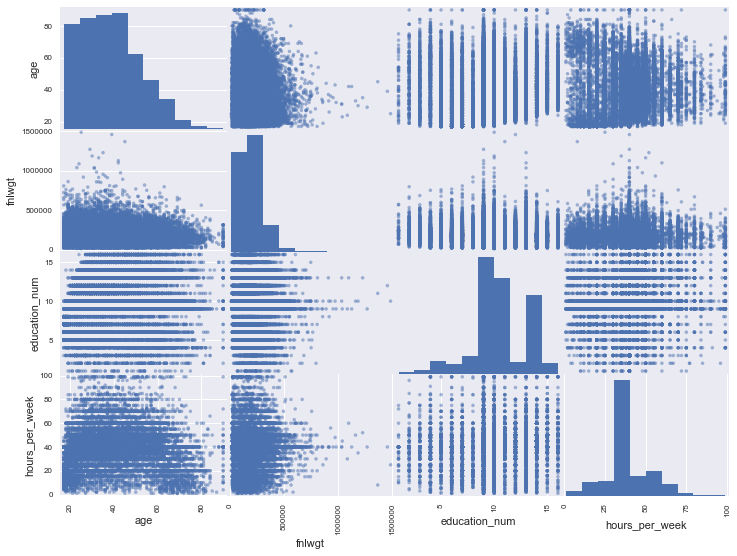

In [86]:
# scatter plot matrix
scatter_matrix(dataset,figsize=(12,9))
plt.show()

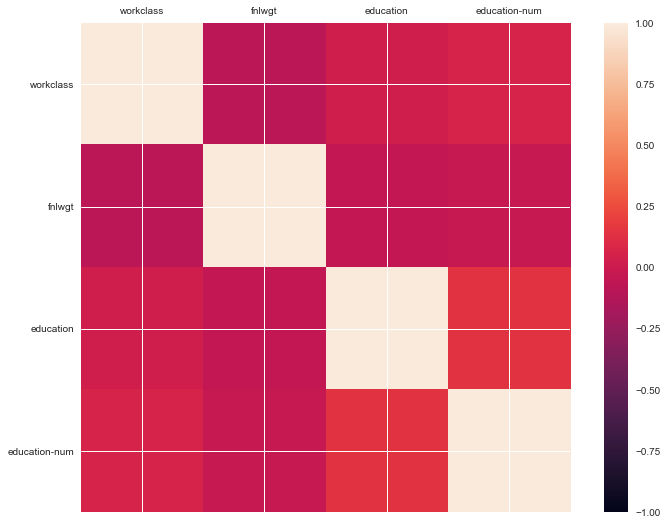

In [87]:
# correlation matrix 
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111)
cax = ax.matshow(dataset.corr(), vmin=-1, vmax=1, interpolation= 'none' )
fig.colorbar(cax)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

There are some levels of correlation between the attributes, further down these will be compared againts the target
variable 'income'.

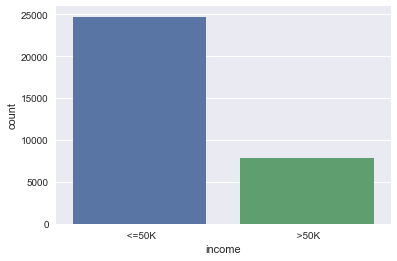

In [88]:
# Target variable: income
sns.countplot(x='income', data=dataset);

Less people hv income >50k

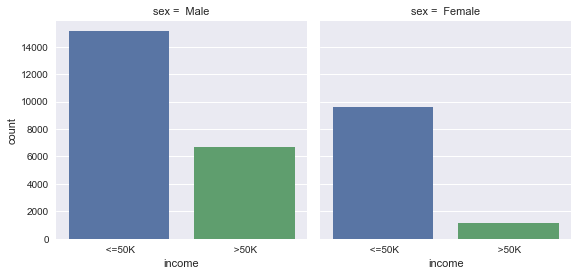

In [115]:
sns.factorplot(x='income', col='sex', kind='count', data=dataset)

A higher number of males earn income <=50k while 
A lower number of Females earn income >50k

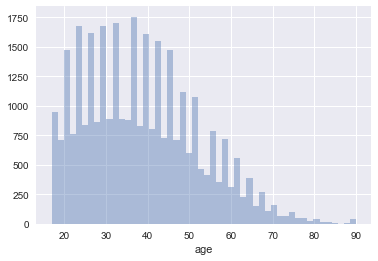

In [19]:
# The Age attribute
sns.distplot(dataset.age, kde=False)

The maximum age is 90 and the minimum age is 17. The noticeable highest number of entries are within the age range of 25  to 50years.

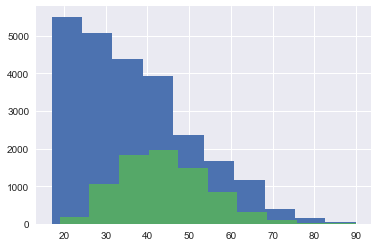

In [20]:
# Comparing the Age and Income attributes
dataset.groupby('income').age.hist(alpha=1);

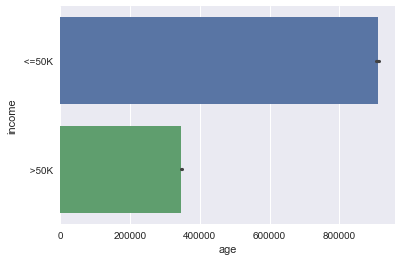

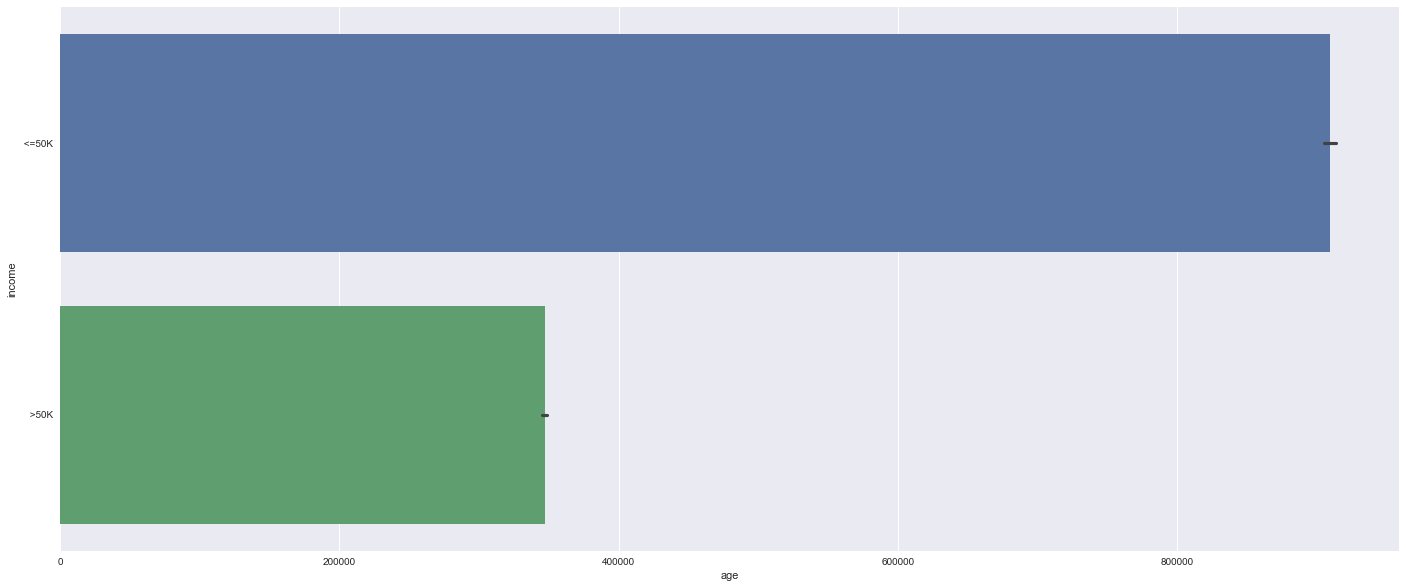

In [125]:
with sns.axes_style('darkgrid'):
    sns.barplot(data=dataset,y='income',x='age',estimator=sum)

In [112]:
# The workclass attribute
with sns.axes_style('darkgrid'):
    sns.barplot(data=dataset,y='income',x='workclass',estimator=sum)

ValueError: Neither the `x` nor `y` variable appears to be numeric.

In [70]:
# Comparing the workclass and Income attributes
dataset.groupby('income').workclass.

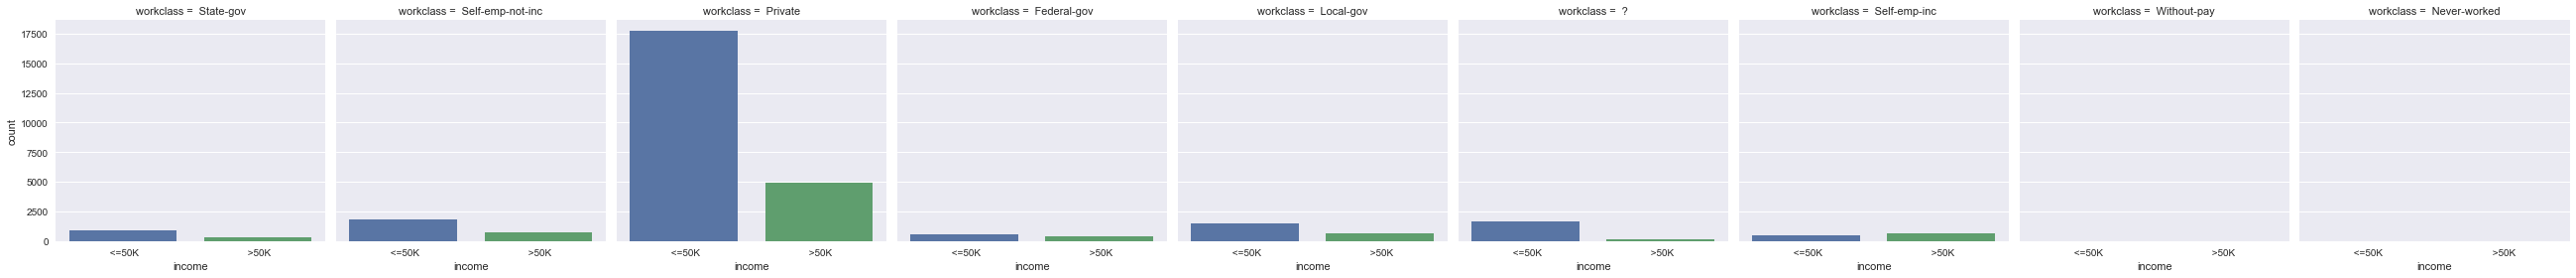

In [23]:
sns.factorplot(x='income', col='workclass', kind='count', data=dataset);

There is an obvious relationship between workclass "Private" and "Income", could it mean either male or female
as long as you have your own business you have a higher likelyhood of earning more, or not???

In [24]:
# The race attribute


In [25]:
# Comparing the race and Income attributes


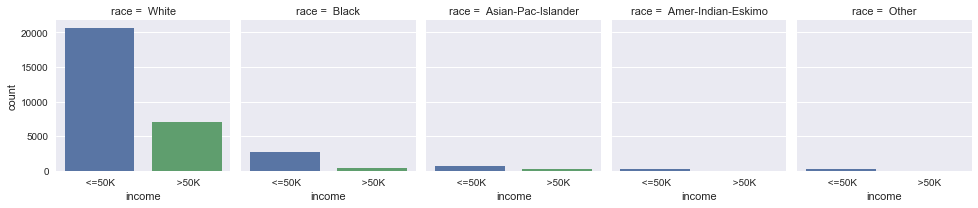

In [26]:
sns.factorplot(x='income', col='race', kind='count', data=dataset,size=3, aspect=.9);

In [27]:
# The relationship attribute


In [28]:
# Comparing the relationship and Income attributes


From the charts it is seen that white females that earn '>50k' also earn more than the sum of all other race incomes.  

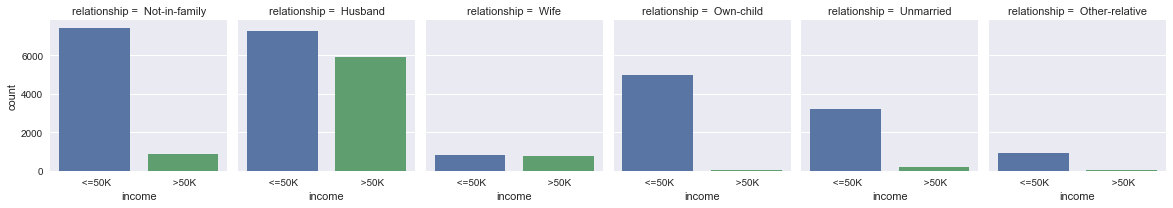

In [29]:
sns.factorplot(x='income', col='relationship', kind='count', data=dataset,size=3, aspect=.9);

'Husband' with income '>50k' are more than the sum of both income categories except 'Not-In-Family'

In [30]:
# The education attribute


In [31]:
# Comparing the education and Income attributes


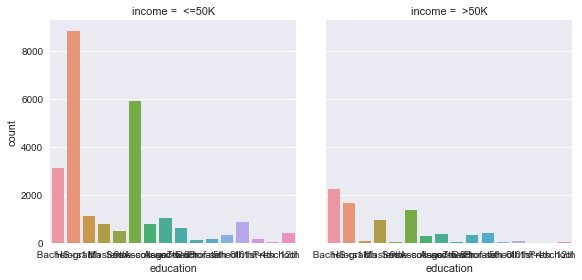

In [32]:
sns.factorplot(x='education', col='income', kind='count', data=dataset);

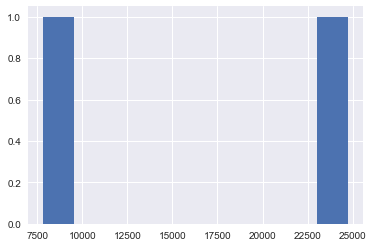

In [106]:
#dataset.groupby('income').education.hist(alpha=1);
dataset.groupby('income').education.aggregate(np.).hist()

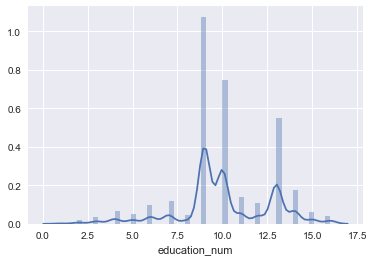

In [34]:
# The education num attribute
sns.distplot(dataset.education_num)

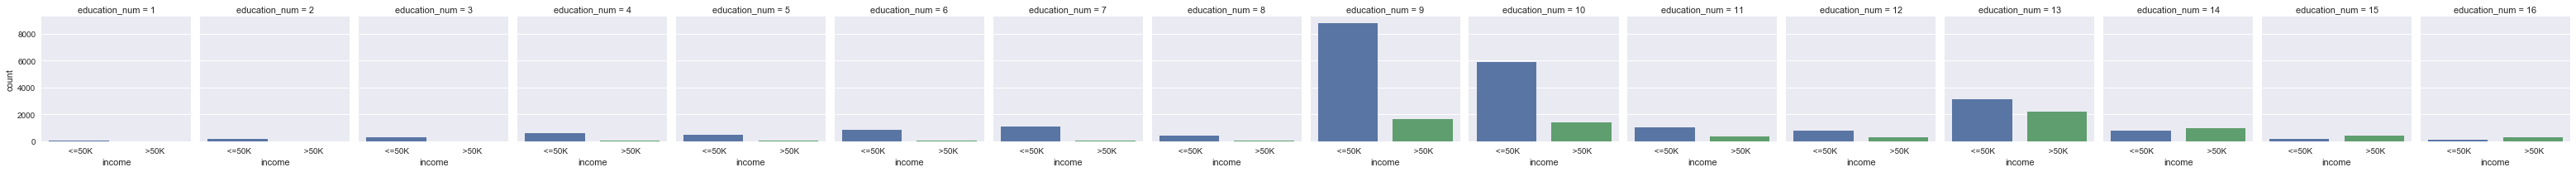

In [35]:
# Comparing the education num and Income attributes
sns.factorplot(x='income', col='education_num', kind='count', data=dataset,size=3, aspect=.9);

In [36]:
# The marital_status attribute


In [37]:
# Comparing the marital_status and Income attributes


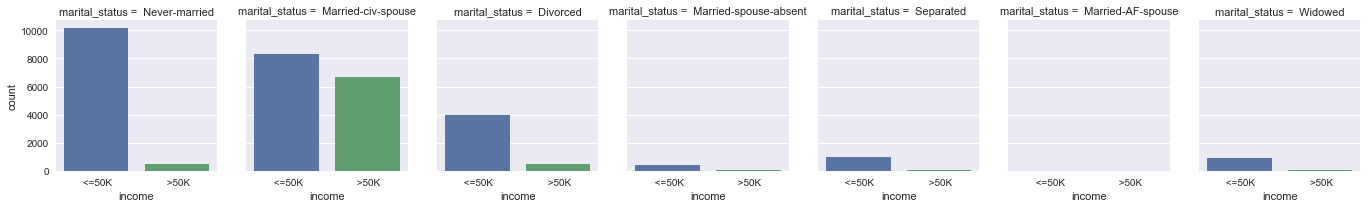

In [38]:
sns.factorplot(x='income', col='marital_status', kind='count', data=dataset,size=3, aspect=.9);

Something definitely noticeable in the charts above :)

In [39]:
# The native_country attribute


In [40]:
# Comparing the native_country and Income attributes


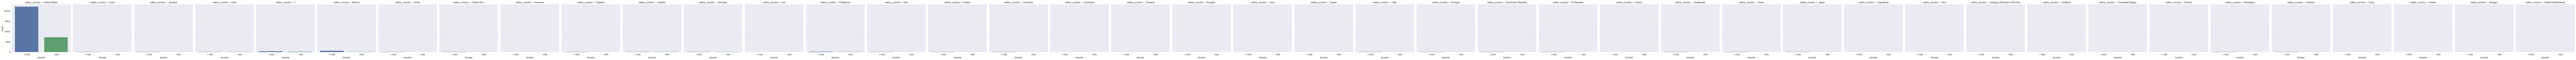

In [41]:
sns.factorplot(x='income', col='native_country', kind='count', data=dataset);


In [42]:
# The occupation attribute


In [43]:
# Comparing the occupation and Income attributes


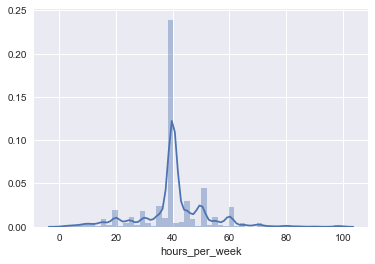

In [44]:
# The hours_per_week attribute
sns.distplot(dataset.hours_per_week)

In [45]:
# Comparing the hours_per_week and Income attributes


In [46]:
dataset_model = dataset.copy()

Convert "income" values to >50K is 1 and <=50K is 0, this will enable usage with more attributes
and as the target variable.

In [47]:
dataset_model['income_target'] = dataset_model.income.apply(lambda x: x.replace("<=50K","0"))

In [48]:
dataset_model['income_target'] = dataset_model.income_target.apply(lambda x: x.replace(">50K","1"))

In [49]:
dataset_model['income_target'] = dataset_model.income_target.apply(lambda x: int(x))

In [50]:
# select only numeric attributes
dataset_numeric_attributes = dataset_model.select_dtypes(include=[np.number])

The DataFrame.corr() method displays the correlation (or relationship) between the columns. 
We'll examine the correlations between the features and the target.

In [51]:
corr = dataset_numeric_attributes.corr()
print (corr['income_target'].sort_values(ascending=False)[:10], '\n')

income_target     1.000000
education_num     0.335154
age               0.234037
hours_per_week    0.229689
fnlwgt           -0.009463
Name: income_target, dtype: float64 



The first 3 features are the most positively correlated with "income", while the last one is the most negatively correlated.

In [52]:
dataset_model.head()

age          workclass  fnlwgt   education  education_num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital_status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   hours_per_week  native_country  income  income_target  
0              40   United-States   <=50K              0  
1              13   United-States   <=50K              0  
2              40   United-States   <=50K              0  
3              40   United-States   <=50K              0  
4              40            Cuba   <=50K              0

In [53]:
del dataset_model['fnlwgt']
del dataset_model['native_country']
del dataset_model['income']

#del dataset_model['education_num'] 
#del dataset_model['marital_status']

In [54]:
# save dataset
dataset_model.to_csv('../data/processed/dataset.csv')

In [55]:
dataset_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 11 columns):
age               32561 non-null int64
workclass         32561 non-null object
education         32561 non-null object
education_num     32561 non-null int64
marital_status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
hours_per_week    32561 non-null int64
income_target     32561 non-null int64
dtypes: int64(4), object(7)
memory usage: 2.7+ MB


In [56]:
# Binning numerical columns
dataset_model['cat_age'] = pd.qcut(dataset_model.age, q=4, labels=False )
dataset_model['cat_education_num']= pd.qcut(dataset_model.education_num, q=4, labels=False)
dataset_model['cat_hours_per_week'] = pd.qcut(dataset_model.hours_per_week, q=4, labels=False,duplicates='drop')
dataset_model.head()

age          workclass   education  education_num       marital_status  \
0   39          State-gov   Bachelors             13        Never-married   
1   50   Self-emp-not-inc   Bachelors             13   Married-civ-spouse   
2   38            Private     HS-grad              9             Divorced   
3   53            Private        11th              7   Married-civ-spouse   
4   28            Private   Bachelors             13   Married-civ-spouse   

           occupation    relationship    race      sex  hours_per_week  \
0        Adm-clerical   Not-in-family   White     Male              40   
1     Exec-managerial         Husband   White     Male              13   
2   Handlers-cleaners   Not-in-family   White     Male              40   
3   Handlers-cleaners         Husband   Black     Male              40   
4      Prof-specialty            Wife   Black   Female              40   

   income_target  cat_age  cat_education_num  cat_hours_per_week  
0              0        2                  3                   0  
1              0        3                  3                   0  
2              0        2                  0                   0  
3              0        3                  0                   0  
4              0        0                  3                   0

In [57]:
# Transform dataset_categorical_attributes into binary variables
dataset_model_dum = pd.get_dummies(dataset_model, drop_first=True)
dataset_model_dum.head()

age  education_num  hours_per_week  income_target  cat_age  \
0   39             13              40              0        2   
1   50             13              13              0        3   
2   38              9              40              0        2   
3   53              7              40              0        3   
4   28             13              40              0        0   

   cat_education_num  cat_hours_per_week  workclass_ Federal-gov  \
0                  3                   0                       0   
1                  3                   0                       0   
2                  0                   0                       0   
3                  0                   0                       0   
4                  3                   0                       0   

   workclass_ Local-gov  workclass_ Never-worked    ...      \
0                     0                        0    ...       
1                     0                        0    ...       
2                     0                        0    ...       
3                     0                        0    ...       
4                     0                        0    ...       

   relationship_ Not-in-family  relationship_ Other-relative  \
0                            1                             0   
1                            0                             0   
2                            1                             0   
3                            0                             0   
4                            0                             0   

   relationship_ Own-child  relationship_ Unmarried  relationship_ Wife  \
0                        0                        0                   0   
1                        0                        0                   0   
2                        0                        0                   0   
3                        0                        0                   0   
4                        0                        0                   1   

   race_ Asian-Pac-Islander  race_ Black  race_ Other  race_ White  sex_ Male  
0                         0            0            0            1          1  
1                         0            0            0            1          1  
2                         0            0            0            1          1  
3                         0            1            0            0          1  
4                         0            1            0            0          0  

[5 rows x 60 columns]

In [58]:
dataset_model_dum['income'] = dataset_model_dum.income_target.apply(lambda x: int(x))
del dataset_model_dum['income_target']
dataset_model_dum.head()

age  education_num  hours_per_week  cat_age  cat_education_num  \
0   39             13              40        2                  3   
1   50             13              13        3                  3   
2   38              9              40        2                  0   
3   53              7              40        3                  0   
4   28             13              40        0                  3   

   cat_hours_per_week  workclass_ Federal-gov  workclass_ Local-gov  \
0                   0                       0                     0   
1                   0                       0                     0   
2                   0                       0                     0   
3                   0                       0                     0   
4                   0                       0                     0   

   workclass_ Never-worked  workclass_ Private   ...    \
0                        0                   0   ...     
1                        0                   0   ...     
2                        0                   1   ...     
3                        0                   1   ...     
4                        0                   1   ...     

   relationship_ Other-relative  relationship_ Own-child  \
0                             0                        0   
1                             0                        0   
2                             0                        0   
3                             0                        0   
4                             0                        0   

   relationship_ Unmarried  relationship_ Wife  race_ Asian-Pac-Islander  \
0                        0                   0                         0   
1                        0                   0                         0   
2                        0                   0                         0   
3                        0                   0                         0   
4                        0                   1                         0   

   race_ Black  race_ Other  race_ White  sex_ Male  income  
0            0            0            1          1       0  
1            0            0            1          1       0  
2            0            0            1          1       0  
3            1            0            0          1       0  
4            1            0            0          0       0  

[5 rows x 60 columns]

In [59]:
numeric_features2 = dataset_model_dum.select_dtypes(include=[np.number])
corr2 = numeric_features2.corr()
print (corr2['income'].sort_values(ascending=False)[:20], '\n')

income                                1.000000
marital_status_ Married-civ-spouse    0.444696
education_num                         0.335154
cat_education_num                     0.327993
cat_age                               0.271493
cat_hours_per_week                    0.243335
age                                   0.234037
hours_per_week                        0.229689
sex_ Male                             0.215980
occupation_ Exec-managerial           0.214861
occupation_ Prof-specialty            0.185866
education_ Bachelors                  0.180485
education_ Masters                    0.174570
education_ Prof-school                0.154907
workclass_ Self-emp-inc               0.139467
education_ Doctorate                  0.132572
relationship_ Wife                    0.123264
race_ White                           0.085224
workclass_ Federal-gov                0.059372
workclass_ Local-gov                  0.033091
Name: income, dtype: float64 



In [60]:
dataset_model_dum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 60 columns):
age                                      32561 non-null int64
education_num                            32561 non-null int64
hours_per_week                           32561 non-null int64
cat_age                                  32561 non-null int64
cat_education_num                        32561 non-null int64
cat_hours_per_week                       32561 non-null int64
workclass_ Federal-gov                   32561 non-null uint8
workclass_ Local-gov                     32561 non-null uint8
workclass_ Never-worked                  32561 non-null uint8
workclass_ Private                       32561 non-null uint8
workclass_ Self-emp-inc                  32561 non-null uint8
workclass_ Self-emp-not-inc              32561 non-null uint8
workclass_ State-gov                     32561 non-null uint8
workclass_ Without-pay                   32561 non-null uint8
education_ 11th        

### Validation Dataset
This is a sample of the data that we hold
back from our analysis and modeling. We use it right at the end of our project to confirm the
accuracy of our final model. It is a smoke test that we can use to see if we messed up and to
give us confidence on our estimates of accuracy on unseen data. We will use 80% of the dataset
for modeling and hold back 20% for validation.

In [61]:
# Split-out validation dataset
array = dataset_model_dum.values
X = array[:,0:59].astype(float)
Y = array[:,59]
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y,
test_size=validation_size, random_state=seed)

### Evaluate Algorithms: Baseline
We don’t know what algorithms will do well on this dataset. Gut feel suggests distance based
algorithms like k-Nearest Neighbors and Support Vector Machines may do well. Let’s design
our test harness. We will use 10-fold cross-validation. The dataset is not too small and this is
a good standard test harness configuration. We will evaluate algorithms using the accuracy
metric. This is a gross metric that will give a quick idea of how correct a given model is. More
useful on binary classification problems like this one.

In [62]:
# Test options and evaluation metric
num_folds = 10
seed = 7
scoring = 'accuracy'

Let’s create a baseline of performance on this problem and spot-check a number of different
algorithms. We will select a suite of different algorithms capable of working on this classification
problem. 

The six algorithms selected include:

Linear Algorithms: Logistic Regression (LR) and Linear Discriminant Analysis (LDA).

Nonlinear Algorithms: Classification and Regression Trees (CART), Support Vector
Machines (SVM), Gaussian Naive Bayes (NB) and k-Nearest Neighbors (KNN).

In [63]:
# Spot-Check Algorithms
models = []
models.append(( 'LR' , LogisticRegression()))
models.append(( 'LDA' , LinearDiscriminantAnalysis()))
models.append(( 'KNN' , KNeighborsClassifier()))
models.append(( 'CART' , DecisionTreeClassifier()))
models.append(( 'NB' , GaussianNB()))
models.append(( 'SVM' , SVC()))

The algorithms all use default tuning parameters. Let’s compare the algorithms. We will
display the mean and standard deviation of accuracy for each algorithm as we calculate it and
collect the results for use later.

In [64]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.836840 (0.009441)


/Users/segunadelowo/miniconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/segunadelowo/miniconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/segunadelowo/miniconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/segunadelowo/miniconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/segunadelowo/miniconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/segunadelowo/miniconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarn

LDA: 0.834651 (0.009870)
KNN: 0.800830 (0.008281)
CART: 0.786356 (0.008300)
NB: 0.615670 (0.011272)
SVM: 0.831196 (0.009184)


Logistic Regression has the best accuracy score followed by SVM.
The variables that are collinear need to be looked into.
The algorithm results are mean accuracy values. Looking at the distribution of accuracy values calculated across cross-validation folds will give a better understanding about the algorithm performance. The box and whisker plots can be used to achieve this.

The results of LR and SVM improved after using increasing num_folds from 5 to 10, but increasing it to 15 didnt result in any improvement

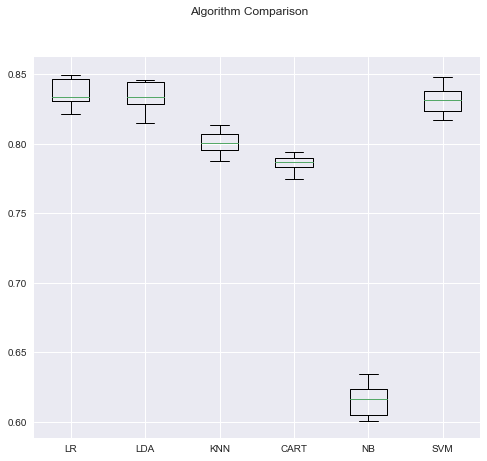

In [65]:
# Compare Algorithms
fig = plt.figure(figsize=(8,7))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

The results shows an ecouraging distribution for LR, this suggests low variance. NB really has poor results.

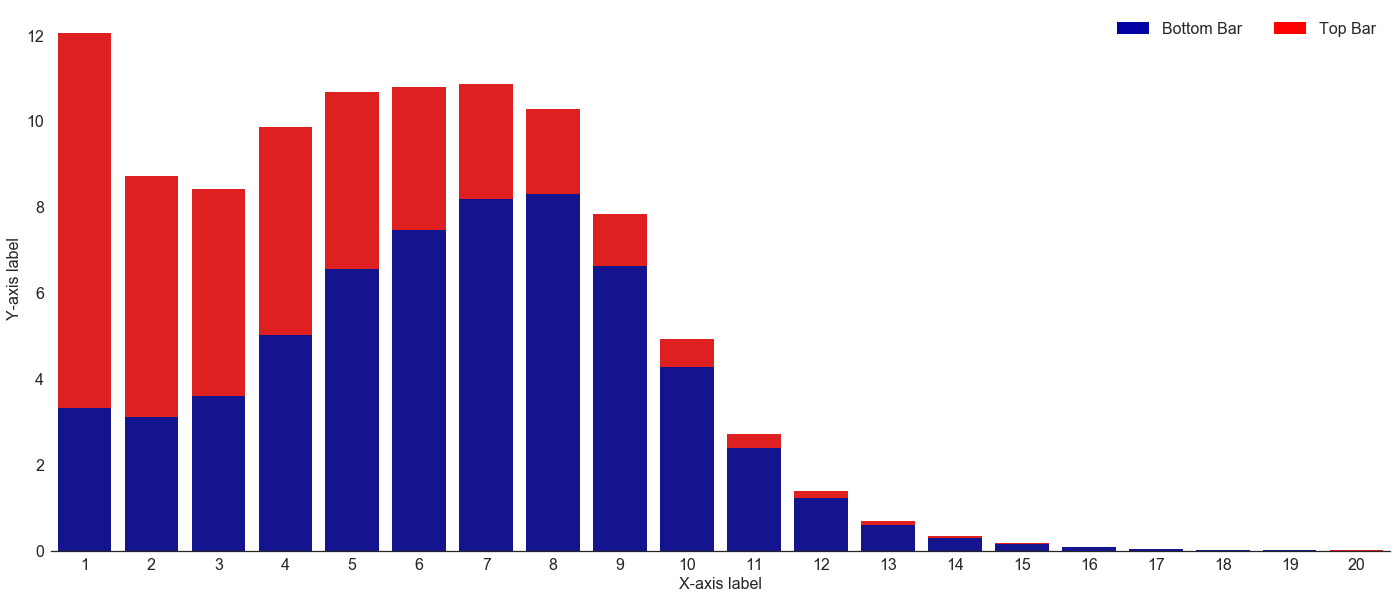

In [116]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

#Read in data & create total column
stacked_bar_data = pd.read_csv("../data/stacked_bar.csv")
stacked_bar_data["total"] = stacked_bar_data.Series1 + stacked_bar_data.Series2

#Set general plot properties
sns.set_style("white")
sns.set_context({"figure.figsize": (24, 10)})

#Plot 1 - background - "total" (top) series
sns.barplot(x = stacked_bar_data.Group, y = stacked_bar_data.total, color = "red")

#Plot 2 - overlay - "bottom" series
bottom_plot = sns.barplot(x = stacked_bar_data.Group, y = stacked_bar_data.Series1, color = "#0000A3")


topbar = plt.Rectangle((0,0),1,1,fc="red", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='#0000A3',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['Bottom Bar', 'Top Bar'], loc=1, ncol = 2, prop={'size':16})
l.draw_frame(False)

#Optional code - Make plot look nicer
sns.despine(left=True)
bottom_plot.set_ylabel("Y-axis label")
bottom_plot.set_xlabel("X-axis label")

#Set fonts to consistent 16pt size
for item in ([bottom_plot.xaxis.label, bottom_plot.yaxis.label] +
             bottom_plot.get_xticklabels() + bottom_plot.get_yticklabels()):
    item.set_fontsize(16)

In [126]:
#stacked_bar_data.groupby('Series1').Series2.hist(alpha=1);
#sns.distplot(stacked_bar_data.Series2, kde=True)
#sns.kdeplot(stacked_bar_data.Series1,stacked_bar_data.Series1, shade=True);